# Ghost Ads
In this exercise we are going to study the difference between the two methods of Random Controlled Trials on advertising effectiveness: 
Please read this first: https://www.thinkwithgoogle.com/intl/en-gb/marketing-resources/data-measurement/a-revolution-in-measuring-ad-effectiveness/

More specifically, we will study whether the claim about the 'ghost ad' method having a much higher power than the 'intend to treat' method, as said by Lewis in this video: https://www.youtube.com/watch?v=_do6ACKKlnw
He claims this is especially true when only targeting a small subgroup of the total population.

### Don't forget to select your venv interpreter!
Install all the packages in the first cell

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy

In [5]:
from IPython.display import Latex, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, norm, binom

## Intend-to-treat vs Ghost ads
The population has two types of people, interested and not-interested. In the Ghost ads example the interested people would be the 'striped T-shirt people' who are the only ones interested in the advertised product. Not-interested people have zero probability of buying your product, whether they were exposed to your ad or not. The interested people (striped T-shirts) have a probability of buying when not exposed to ads (take for example 0.2) and a sligthly higher probability when they are exposed to ads (take for example 0.3). Also, the bidding algorithm doesn't always correctly identify a interested person (as can be seen in the picture below), so add a probability of misclassification (for example 0.1).
![True Population](GhostAds_1._Ideal_experiment_FINAL_v2.png)

#### To summarize, these are the different possibilities for the people in the population

|bucket|interested|classified (as interested)|test/control group|treated (advertised to)|probability of buying|intend-to-treat|ghost-ad|
|---|---	|---	|---	|---	|---	|---	|
|A|yes|yes|test|yes|0.3|    test|test|
|B|yes|yes|control|no|0.2|   	control|control|
|C|yes|no|test|no|0.2|   	test|not used|
|D|yes|no|control|no|0.2|   	control|not used|
|E|no|yes|test|yes|0.0|   	test|test|
|F|no|yes|control|no|0.0|   	control|control|
|G|no|no|test|no|0.0|   	test|not used|
|H|no|no|control|no|0.0|   	control|not used|

Now let's see the difference between intend-to-treat and the ghost ad metric, in what data is used to calculate effects. The reason why ghost-ad testing has greater power is that we can reduce 'noise' from our testing method by removing the user who are not treated in the test group, because they are not targeted by the algorithm, and removing user who would have not be advertised to in the control group. Ideally, we would always want to use the ghost-ad method for testing, however, in many cases it might technically not be possible to measure what users would and would not have received treatment in the control group. We therefore sometimes need to use intend-to-treat. The picture below illustrates the situation with intend-to-treat:
![Intend to Treat](GhostAds_3._Intend_to_treat_FINAL_v2.png)

### Creating the data
We now can make the data generating function. We do not create individual user data and sample from the bernoulli distribution (which might be easier for illustration) but we sample for each of the eight scenario's (buckets) from the binomial distribution, to fasten up the later simulations. Therefore we need to create an array with the amount of people $n$ for bucket A to H and an array with purchase probability $p$ for buckets A to H.

How many people fall into the different buckets depends om: how much of the population is interested in your product, how good your targeting algorithm is in identifyng these people (probability of misclassification) and how many of these people identifyed by your algorithm you actually advertise to. For example, if you run a 50/50 split A/B test, 50% of those people you advertise to and the others are in the control group.

In [54]:
def create_n_and_p(p_conversion_interested_treated = 0.3, 
                p_conversion_interested_not_treated = 0.2, 
                p_conversion_not_interested = 0,
                p_is_interested = 0.5,
                p_is_control_group = 0.5,
                p_false_positive = 0.1, 
                p_false_negative = 0.1, 
                n = 1000):
    n_A = np.round(p_is_interested*(1-p_false_positive)*(1-p_is_control_group)*n)    
    n_B = np.round(p_is_interested*(1-p_false_positive)*p_is_control_group*n)   
    n_C = np.round(p_is_interested*p_false_negative*p_is_control_group*n)
    n_D = np.round(p_is_interested*p_false_negative*(1-p_is_control_group)*n)
    n_E = np.round((1-p_is_interested)*p_false_positive*(1-p_is_control_group)*n)    
    n_F = np.round((1-p_is_interested)*p_false_positive*p_is_control_group*n)   
    n_G = np.round((1-p_is_interested)*(1-p_false_negative)*p_is_control_group*n)
    n_H = np.round((1-p_is_interested)*(1-p_false_negative)*(1-p_is_control_group)*n)
    n_buckets = [n_A, n_B, n_C, n_D, n_E, n_F, n_G, n_H]
    n_buckets = np.array(n_buckets).astype(int)
    p_A = p_conversion_interested_treated
    p_B = p_C = p_D = p_conversion_interested_not_treated
    p_E = p_F = p_G = p_H = p_conversion_not_interested
    p_buckets = [p_A, p_B, p_C, p_D, p_E, p_F, p_G, p_H]
    p_buckets = np.array(p_buckets)
    return n_buckets, p_buckets
    

def create_data(n_buckets, p_buckets):
    purchased = binom.rvs(n=n_buckets, p=p_buckets)
    purchased = np.array(purchased)
    intend_to_treat_data = {}
    intend_to_treat_data['users_test'] = sum(n_buckets[[0,2,4,6]])
    intend_to_treat_data['users_control'] = sum(n_buckets[[1,3,4,7]])
    intend_to_treat_data['purchased_test'] = sum(purchased[[0,2,4,6]])
    intend_to_treat_data['purchased_control'] = sum(purchased[[1,3,4,7]])
    ghost_ad_data = {}
    ghost_ad_data['users_test'] = sum(n_buckets[[0,4]])
    ghost_ad_data['users_control'] = sum(n_buckets[[1,5]])
    ghost_ad_data['purchased_test'] = sum(purchased[[0,4]])
    ghost_ad_data['purchased_control'] = sum(purchased[[1,5]])
    return intend_to_treat_data, ghost_ad_data

In [52]:
n_buckets, p_buckets = create_n_and_p()
intend_to_treat_data, ghost_ad_data = create_data(n_buckets, p_buckets)
print(intend_to_treat_data)
print(ghost_ad_data)

1000
500
500
[0.3 0.2 0.2 0.2 0.  0.  0.  0. ]
{'users_test': 500, 'users_comtrol': 500, 'purchased_test': 72, 'purchased_control': 49}
{'users_test': 250, 'users_comtrol': 250, 'purchased_test': 65, 'purchased_control': 43}


## Create a function to perform the t-test

In [58]:
def run_t_test(users_a, users_b, converted_a, converted_b, alpha):
    p_a_hat = converted_a / users_a
    p_b_hat = converted_b / users_b
    var_p_a_hat = p_a_hat * (1-p_a_hat)
    var_p_b_hat = p_b_hat * (1-p_b_hat)
    diff = p_b_hat - p_a_hat
    diff_std_rerror = np.power((var_p_a_hat/users_a + var_p_b_hat/users_b), 0.5)
    t_stat = diff / diff_std_rerror
    p_val = norm.cdf(t_stat)
    sign_bound = norm.ppf(1-alpha/2) * diff_std_rerror
    power = 1 - norm.cdf(sign_bound, loc=diff, scale=diff_std_rerror)
    return p_val, power

## Run the analysis
Now you have everything ready to start analysis. Run simulations with different methods and calculate the power of both tests.
* Try for different sample sizes $N$
* Try for different size of 'interested' groups by changing p_is_interested
* Try for different rates of misclassification p_false_positive and p_false_negative

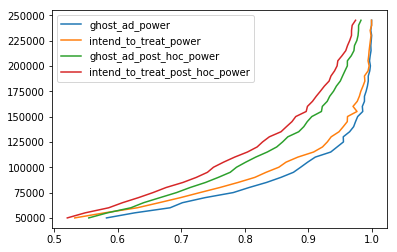

In [85]:
SIMULATIONS = 3000
p_conversion_interested_treated = 0.3
p_conversion_interested_not_treated = 0.2
p_conversion_not_interested = 0
p_is_interested = 0.01
p_is_control_group = 0.5
p_false_positive = p_false_negative = 0.1
alpha = 0.05

Ns = [i*5000 for i in range(10,50)]

intend_to_treat_effects = []
intend_to_treat_conversion_effects = []
intend_to_treat_powers = []
intend_to_treat_post_hoc_powers = []

ghost_ad_effects = []
ghost_ad_conversion_effects = []
ghost_ad_powers = []
ghost_ad_post_hoc_powers = []

def run_simulations_for_n(N, SIMULATIONS):
    
    ghost_ad_treatment_effects = []
    ghost_ad_pvalues = []
    ghost_ad_powers = []
    intend_to_treat_treatment_effects = []
    intend_to_treat_pvalues = []
    intend_to_treat_powers = []
    
    n_buckets, p_buckets = create_n_and_p(p_conversion_interested_treated = p_conversion_interested_treated, 
                p_conversion_interested_not_treated = p_conversion_interested_not_treated, 
                p_conversion_not_interested = p_conversion_not_interested,
                p_is_interested = p_is_interested,
                p_is_control_group = p_is_control_group,
                p_false_positive = p_false_positive, 
                p_false_negative = p_false_negative, 
                n = N)
    
    for i in range(SIMULATIONS):
        intend_to_treat_data, ghost_ad_data = create_data(n_buckets, p_buckets)
        data = intend_to_treat_data
        
        intend_to_treat_treatment_effect = data['purchased_test'] / data['users_test'] - \
                                    data['purchased_test'] / data['users_control']
        intend_to_treat_pvalue, intend_to_treat_power = run_t_test(data['users_control'], data['users_test'],
                                      data['purchased_control'], data['purchased_test'], alpha)
        data = ghost_ad_data
        ghost_ad_treatment_effect = data['purchased_test'] / data['users_test'] - \
                                    data['purchased_test'] / data['users_control']
        ghost_ad_pvalue, ghost_ad_power = run_t_test(data['users_control'], data['users_test'],
                                      data['purchased_control'], data['purchased_test'], alpha)

        intend_to_treat_treatment_effects += [intend_to_treat_pvalue]
        intend_to_treat_pvalues += [intend_to_treat_pvalue]
        intend_to_treat_powers += [intend_to_treat_power]
        ghost_ad_treatment_effects += [ghost_ad_treatment_effect]
        ghost_ad_pvalues += [ghost_ad_pvalue]
        ghost_ad_powers += [ghost_ad_power]
    
    intend_to_treat_treatment_effect = np.mean(intend_to_treat_treatment_effects)
    intend_to_treat_power = np.sum(np.array(intend_to_treat_pvalues) > (1-alpha/2)) / SIMULATIONS
    intend_to_treat_post_hoc_power = np.mean(intend_to_treat_powers)
    ghost_ad_treatment_effect = np.mean(np.array(ghost_ad_treatment_effects))
    ghost_ad_power = np.sum(np.array(ghost_ad_pvalues) > (1-alpha/2)) / SIMULATIONS
    ghost_ad_post_hoc_power = np.mean(ghost_ad_powers)

    return (intend_to_treat_treatment_effect, 
            intend_to_treat_power,
            intend_to_treat_post_hoc_power,
            ghost_ad_treatment_effect, 
            ghost_ad_power,
            ghost_ad_post_hoc_power)


for N in Ns:
    (intend_to_treat_treatment_effect, 
            intend_to_treat_power,
            intend_to_treat_post_hoc_power,
            ghost_ad_treatment_effect, 
            ghost_ad_power,
            ghost_ad_post_hoc_power) = run_simulations_for_n(N, SIMULATIONS)
    
    ghost_ad_effects += [ghost_ad_treatment_effect]
    ghost_ad_conversion_effects += [ghost_ad_treatment_effect * p_is_interested * N]
    ghost_ad_powers += [ghost_ad_power]  
    ghost_ad_post_hoc_powers += [ghost_ad_post_hoc_power]  
    intend_to_treat_effects += [intend_to_treat_treatment_effect]
    intend_to_treat_conversion_effects += [intend_to_treat_treatment_effect * N]
    intend_to_treat_powers += [intend_to_treat_power]
    intend_to_treat_post_hoc_powers += [intend_to_treat_post_hoc_power]
    
    #print(ghost_ad_power)
    #print(intend_to_treat_power)                        
                        
plt.plot(ghost_ad_powers, Ns, label='ghost_ad_power')
plt.plot(intend_to_treat_powers, Ns, label='intend_to_treat_power')
plt.plot(ghost_ad_post_hoc_powers, Ns, label='ghost_ad_post_hoc_power')
plt.plot(intend_to_treat_post_hoc_powers, Ns, label='intend_to_treat_post_hoc_power')
plt.legend()
plt.show()     

### intuition behind why this is the case
Why doesn't give the ghost ad method give a much higher power? One would expect that, because the variance of your estimators is going down, because of the reduced noise from observations that did in fact not get the treated and wouldn't have had the treatment. My intiution behind why this is the case is the following:

The standard of the estimator in the unpaired unequal variances t-test is the following:

$\sqrt{\sigma^2_{test}/n_{test} + \sigma^2_{control}/n_{control}}$

Now my intuition is that while $\sigma_{test}$ and $\sigma_{control}$ are getting bigger because of the noise that's introduced by including the untreated and would not be treated people, this is largely canceled out by the fact that $n_{test}$ and $n_{control}$ have also grown.

### considerations
* Of course I'm over-simplyfing the simulation. In fact there might be a wide range of purchase probabilities and effects which could somehow make ghost ads more beneficial than intend-to-treat. However, I do think statistics should be quite robust in calculating average effects if the true underlying effect is varying. This would be interesting to dive into.
* It might be that my assumptions in how to calculate the power and p-values is oversimplified, or that I'm making some assumptions I can't make. However, I do think these calculations are the calculations that are generally used.
* In the case of a non-binary outcome (like revenue) things might also be different.